In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
from genplasmid.dataset import genbank_to_glm2, read_genbank
import warnings
from datasets import load_dataset

from Bio import BiopythonParserWarning

# Suppress the specific warning
warnings.filterwarnings("ignore", category=BiopythonParserWarning, message="Attempting to parse malformed locus line:")

/srv/home/wconnell/anaconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data = load_dataset("wconnell/openplasmid")
data = data.filter(lambda x: x['GenBank Raw'] != '')
data = data.map(lambda x: {'glm2_sequence': genbank_to_glm2(x['GenBank Raw'])})

# metadata
all_feat = data['train'].to_pandas()
all_feat['GenBank'] = all_feat['GenBank Raw'].map(read_genbank)


In [ ]:
import re

def clean_gene_name(gene):
    # Remove common prefixes and suffixes
    gene = re.sub(r'^(human|mouse|rat|h|m|r)\s*', '', gene, flags=re.IGNORECASE)
    gene = re.sub(r'\s*(gene|protein)$', '', gene, flags=re.IGNORECASE)
    
    # Remove parentheses and their contents
    gene = re.sub(r'\s*\([^)]*\)', '', gene)
    
    # Remove specific strings
    gene = re.sub(r'(or nptII)', '', gene)
    
    # Standardize common gene names
    gene_map = {
        'neo': 'neomycin resistance',
        'amp': 'ampicillin resistance',
        'gfp': 'GFP',
        'egfp': 'GFP',
        'rfp': 'RFP',
        'dsred': 'RFP',
        'kan': 'kanamycin resistance',
    }
    
    for key, value in gene_map.items():
        if re.search(rf'\b{key}\b', gene, re.IGNORECASE):
            return value
    
    return gene.strip().lower()

def extract_cds_genes(record):
    genes = []
    for feature in record.features:
        if feature.type == 'CDS':
            gene = feature.qualifiers.get('gene', [])
            product = feature.qualifiers.get('product', [])
            if gene:
                genes.append(clean_gene_name(gene[0]))
            elif product:
                genes.append(clean_gene_name(product[0]))
    return genes

def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    total_count = len(sequence)
    return gc_count / total_count if total_count > 0 else 0


In [ ]:
# extract sequence features
all_feat['CDS genes'] = all_feat['GenBank'].map(extract_cds_genes)
all_feat['Sequence length'] = all_feat['GenBank'].map(lambda x: len(x.seq))
all_feat['GC content'] = all_feat['GenBank'].map(calculate_gc_content)

In [ ]:
import itertools
from collections import Counter

# count labels
feature_counts = Counter(list(itertools.chain.from_iterable(all_feat['CDS genes'].values)))
feature_counts.most_common(15)
exclude = ['bla', 'op']
keywords = [key for key, value in dict(feature_counts.most_common(15)).items() if key not in exclude]
keywords = keywords[::-1]
keywords

# keywords = ['gfp', 'cas9', '6xhis', 'RFP', 'factor xa', 'aph-ii', 'aph-ia', 'laci', 't antigen']

In [ ]:
def map_genes(gene):
    for keyword in keywords:
        if re.search(keyword, " ".join(gene), re.IGNORECASE):
            return keyword
    return None

all_feat['CDS curated features'] = all_feat['CDS genes'].map(map_genes)

In [ ]:
# def map_genes(genes):
#     keywords = ['cas9', 'RFP', 'factor xa', 'gp41 peptide', 'luciferase', 'aph-ii', 'aph-ia', 'laci', 't antigen', 'factor xa', 'gfp', '6xhis', 'op',]
#     for gene in genes:
#         for keyword in keywords:
#             if re.search(keyword, gene, re.IGNORECASE):
#                 return keyword
#     return None

# all_feat['CDS curated features'] = all_feat['CDS features'].map(map_genes)

# Count of rows for each mapped gene and None
gene_counts = all_feat['CDS curated features'].value_counts(dropna=False)
print("\nCounts for each mapped gene:")
print(gene_counts)

# Percentage of rows with a mapped gene
mapped_percentage = (all_feat['CDS curated features'].notna().sum() / len(all_feat)) * 100
print(f"\nPercentage of rows with a mapped gene: {mapped_percentage:.2f}%")


In [ ]:
# Initialize a new column with empty lists
all_feat['Entrez Genes'] = [[] for _ in range(len(all_feat))]

for idx, row in all_feat.iterrows():
    for i in range(1, 4):
        insert = row[f'Gene/Insert {i}']
        if isinstance(insert, dict) and insert.get('Entrez Gene', None):
            all_feat.at[idx, 'Entrez Genes'].append(insert['Entrez Gene'].upper())

# count the most common entrez genes
common_entrez = all_feat['Entrez Genes'].explode().value_counts().head(20).index.tolist()

# Create a reverse lookup dictionary for common_entrez
common_entrez_priority = {gene: i for i, gene in enumerate(reversed(common_entrez))}

def get_highest_priority_gene(genes):
    present_genes = [gene for gene in genes if gene in common_entrez_priority]
    if present_genes:
        return max(present_genes, key=lambda g: common_entrez_priority[g])
    return None

# Create a new column 'Common Entrez Gene' with the highest priority gene
all_feat['Common Entrez Gene'] = all_feat['Entrez Genes'].apply(get_highest_priority_gene)

# Display the first few rows to verify the new column
print(all_feat[['Entrez Genes', 'Common Entrez Gene']].head(10))

In [ ]:
import scanpy as sc

if 'embeddings' not in locals():
    embeddings = np.load('data/glm2v2_embeddings.npy')

adata = sc.AnnData(embeddings, obs=all_feat)
adata.obs['log(seq_len)'] = np.log10(adata.obs['Sequence length'])
sc.tl.pca(adata)
adata

In [ ]:
sc.pl.pca(
    adata, 
    color=['CDS curated features'],
    palette=sc.pl.palettes.vega_20_scanpy,
    ncols=3,
    vmin='p5',
    vmax='p95',
    vcenter='p50',
    na_color='lightgrey', # set to transparent instead of 'lightgrey'
)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans

# Filter out rows where 'CDS curated features' is None
filtered_adata = adata[adata.obs['CDS curated features'].notna()]

# Perform Spectral clustering on the PCA results
from sklearn.cluster import SpectralClustering

n_clusters = len(filtered_adata.obs['CDS curated features'].unique())
spectral = SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors')
cluster_labels = spectral.fit_predict(filtered_adata.obsm['X_pca'])
# n_clusters = len(filtered_adata.obs['CDS curated features'].unique())
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(filtered_adata.obsm['X_pca'])

# Get the 'CDS curated features' labels
gene_labels = filtered_adata.obs['CDS curated features'].astype('category').cat.codes

# Calculate metrics
nmi_score = normalized_mutual_info_score(gene_labels, cluster_labels)
ari_score = adjusted_rand_score(gene_labels, cluster_labels)

print(f"Normalized Mutual Information: {nmi_score:.4f}")
print(f"Adjusted Rand Index: {ari_score:.4f}")
print("")
# Optionally, visualize the clustering results
import scanpy as sc

filtered_adata.obs['KMeans_cluster'] = cluster_labels
filtered_adata.obs['KMeans_cluster'] = filtered_adata.obs['KMeans_cluster'].astype(str)
sc.pl.pca(
    filtered_adata,
    color=['CDS curated features', 'KMeans_cluster'],
    ncols=2,
    # legend_loc='on data',
    legend_fontsize='xx-small',
    title=['CDS curated features', 'KMeans Clusters']
)

In [ ]:
sc.pl.pca(
    adata, 
    color=['Common Entrez Gene'],
    palette=sc.pl.palettes.vega_20_scanpy,
    ncols=3,
    vmin='p5',
    vmax='p95',
    vcenter='p50',
    na_color='none', # set to transparent instead of 'lightgrey'
)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans

# Filter out rows where 'Common Entrez Gene' is None
filtered_adata = adata[adata.obs['Common Entrez Gene'].notna()]

# Perform K-means clustering on the PCA results
n_clusters = len(filtered_adata.obs['Common Entrez Gene'].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(filtered_adata.obsm['X_pca'])

# Get the 'Common Entrez Gene' labels
gene_labels = filtered_adata.obs['Common Entrez Gene'].astype('category').cat.codes

# Calculate metrics
nmi_score = normalized_mutual_info_score(gene_labels, cluster_labels)
ari_score = adjusted_rand_score(gene_labels, cluster_labels)

print(f"Normalized Mutual Information: {nmi_score:.4f}")
print(f"Adjusted Rand Index: {ari_score:.4f}")
print("")
# Optionally, visualize the clustering results
import scanpy as sc

filtered_adata.obs['KMeans_cluster'] = cluster_labels
sc.pl.pca(
    filtered_adata,
    color=['Common Entrez Gene', 'KMeans_cluster'],
    ncols=2,
    legend_loc='on data',
    legend_fontsize='xx-small',
    title=['Common Entrez Gene', 'KMeans Clusters']
)

In [ ]:
sc.pp.neighbors(filtered_adata)
sc.tl.umap(filtered_adata)
sc.pl.umap(
    filtered_adata,
    color=['Common Entrez Gene', 'KMeans_cluster'],
    ncols=2,
    legend_loc='on data',
    legend_fontsize='xx-small',
    title=['Common Entrez Gene', 'KMeans Clusters']
)

In [ ]:
# Create a new column for each category and delete if all NaN
for category in list(category_mapping.keys()):
    adata.obs[category] = adata.obs['Categories'].map(lambda x: category if category in x else np.nan)
    if adata.obs[category].isna().all():
        del adata.obs[category]
        print(f"Deleted empty category: {category}")

# Plot PCA for the first 10 non-empty categories
plotted_categories = 0
for category in adata.obs.columns:
    if category in category_mapping.keys():
        sc.pl.pca(
            adata,
            color=[category],
            palette=['#ff7f0e'],
            title=category,
            na_color='lightgrey',
        )
        plotted_categories += 1
        if plotted_categories == 10:
            break

print(f"Total non-empty categories: {len([col for col in adata.obs.columns if col in category_mapping])}")

## Variant analysis

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

# read multiple files into pandas df
fname = "1yfp_A_esm3_sm_open_v1_generation_structure_local.csv"
fpaths = [f"results/seq_variants/pod{i}/{fname}" for i in [1,3,4]]
df = pd.concat([pd.read_csv(fpath) for fpath in fpaths])
df['Sequence_used'] = df['Sequence_used'].map(lambda x: True if x=="{True}" else False)
df['Sequence_Identity'] = df['Sequence_Identity'].str.strip("%").astype(float)
cols = list(df.columns)
df['ID'] = df.index
df = df[['ID'] + cols]
# df.to_csv("results/seq_variants/variants.csv", index=False)
df['log(backbone_rmsd)'] = np.log(df['Backbone_RMSD'])
df.head()

,ID,Masking_Percentage,Sequence_used,Generated_Sequence,Sequence_Identity,Backbone_RMSD,log(backbone_rmsd)
0,0,0.9,True,NGLKAFQGKRPVEVKMEGDVDGVKFEVDGNGEIDSTTGSCDLKYIC...,38.84,2.09,0.737164
1,1,0.9,False,MSDYKFRISTFYPVSNKSINQLAKTLIKYRGEYWYTGLKTQNRWIY...,14.35,11.16,2.412336
2,2,0.9,True,KGLDIFKGMKPVRVELQGDIDGTKFSLKGQGTTNFMTGEMHLELVC...,37.05,2.70,0.993252
3,3,0.9,False,KPCTFTVAGVTDIDEQIRTFDGVKFYKDFHQFLIDVEGITASEIHA...,18.55,16.52,2.804572
4,4,0.9,True,PGRATFRGAVRVLLLADGNIDGHRYTLRGRGVAVPRTGKTSLKFVA...,30.80,13.06,2.569554


<Axes: xlabel='Sequence_Identity', ylabel='log(backbone_rmsd)'>

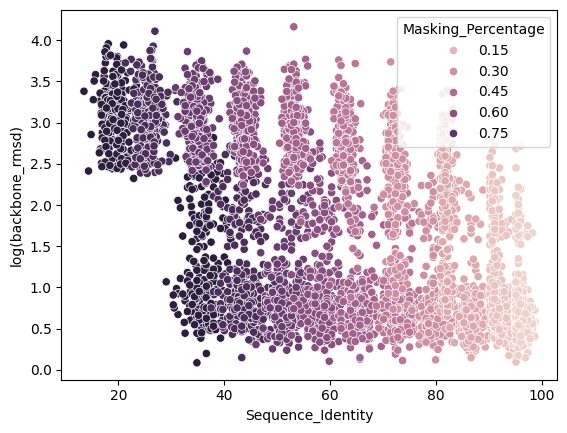

In [6]:
import seaborn as sns

# Create the scatter plot
sns.scatterplot(x='Sequence_Identity', y='log(backbone_rmsd)', hue='Masking_Percentage', data=df)

<Axes: >

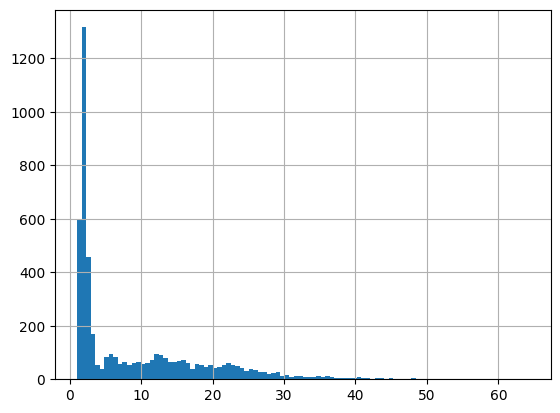

In [7]:
df['Backbone_RMSD'].hist(bins=100)

In [8]:
foo = df[(df['Sequence_Identity'] < 50) & (df['Backbone_RMSD'] < 3)].sort_values('Backbone_RMSD')
foo['Generated_Sequence'].iloc[0]
foo.head()

'MGTDLLRGKVPVEITVSADIDGHQFTLRGEGTVDPSTGEARIRFICESGSLPIPMYALATNLVQYTVRIPEEFRSYDFFKSSLPQGFLQQRTIHMENDGSIIQEARICLEGSCLVNRVSLTGHGFRPDGPILRRRLLPNSSPFDWYFKPDQGGRGLAIHFVASLPMEDGQAYFQHHTERIYPLGPGEFVIPPPHRLSMQATGSQDPDLKEPHVLIREEMALTGV'

,ID,Masking_Percentage,Sequence_used,Generated_Sequence,Sequence_Identity,Backbone_RMSD,log(backbone_rmsd)
226,226,0.9,True,MGTDLLRGKVPVEITVSADIDGHQFTLRGEGTVDPSTGEARIRFIC...,34.82,1.09,0.086178
766,766,0.8,True,MGKELFNGVVPLKVDIKGDVDGKKFQLKGMGDVDPTQGIQKLKYIC...,43.30,1.16,0.148420
194,194,0.9,True,SGRSLYSGEVVIDINLSGDIDGRKFTVTGNGTADASRGSTNLRFVS...,36.61,1.22,0.198851
1244,1244,0.7,True,MGRERFTGVVRVHVETEGNISGHIFAISGEGKGDASTGKLDLKLVC...,49.11,1.29,0.254642
1332,1332,0.7,True,EGMELLEGPVNIKLELKANIDGKKFKVTGDGEVDAKTGRLALTQIA...,45.98,1.36,0.307485


In [11]:
df['Backbone_RMSD'].describe()

count    5000.000000
mean        9.143484
std         9.496264
min         1.090000
25%         1.970000
50%         3.390000
75%        14.662500
max        64.180000
Name: Backbone_RMSD, dtype: float64

In [84]:
from collections import Counter

# Function to calculate entropy at each sequence position
def calculate_entropy(column):
    sequences = column.tolist()
    sequence_length = len(sequences[0])
    entropy_list = []
    
    for i in range(sequence_length):
        # Extract the i-th character from each sequence
        characters_at_position = [seq[i] for seq in sequences]
        
        # Count the frequency of each character
        char_counts = Counter(characters_at_position)
        
        # Calculate probabilities for each character
        total = len(characters_at_position)
        probabilities = [count / total for count in char_counts.values()]
        
        # Calculate entropy for this position
        entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
        entropy_list.append(entropy)
    
    return entropy_list

# Calculate entropy at each sequence position
entropy_values = calculate_entropy(df['Generated_Sequence'])

# Adding entropy values to a new dataframe
entropy_df = pd.DataFrame({
    'Position': list(range(len(entropy_values))),
    'Entropy': entropy_values
})

<Axes: xlabel='Position', ylabel='Entropy'>

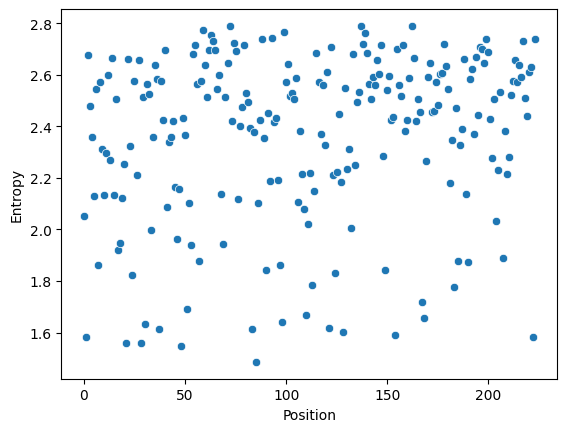

In [85]:
sns.scatterplot(x='Position', y='Entropy', data=entropy_df)

,Position,Entropy
85,85,0.008988
21,21,0.050867
30,30,0.050867
121,121,0.061373
154,154,0.077812
128,128,0.088316
37,37,0.091575
168,168,0.101129
28,28,0.112990
222,222,0.122914


<Axes: xlabel='Position', ylabel='Entropy'>

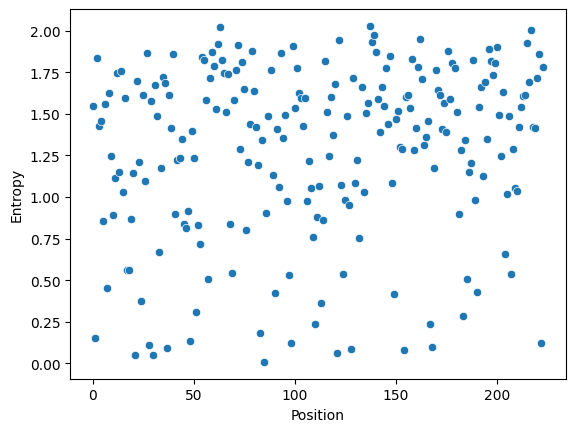

In [86]:
# Calculate entropy at each sequence position
entropy_values = calculate_entropy(df[df['Backbone_RMSD'] < 2]['Generated_Sequence'])

# Adding entropy values to a new dataframe
entropy_df = pd.DataFrame({
    'Position': list(range(0, len(entropy_values))),
    'Entropy': entropy_values
})

entropy_df.sort_values('Entropy', ascending=True).head(10)
sns.scatterplot(x='Position', y='Entropy', data=entropy_df)

In [88]:
def calculate_entropy_by_subset(df, masking_col, sequence_col):
    results = []
    for x in df[masking_col].unique():
        subset = df[df[masking_col] == x]
        entropy_list = calculate_entropy(subset[sequence_col])
        for i, entropy in enumerate(entropy_list):
            results.append({
                masking_col: x,
                'Position': i,
                'Entropy': entropy
            })
    return pd.DataFrame(results)

# Calculating entropy for each subset
entropy_by_subset_df = calculate_entropy_by_subset(df[df['Backbone_RMSD'] < 2], 'Masking_Percentage', 'Generated_Sequence')


In [89]:
import matplotlib.pyplot as plt

# for i in entropy_by_subset_df['Masking_Percentage'].unique():
#     sns.scatterplot(x='Position', y='Entropy', 
#                     data=entropy_by_subset_df[entropy_by_subset_df['Masking_Percentage'] == i],
#                     )
#     plt.title(f'Masking Percentage {i}')
#     plt.show()


In [108]:
entropy_by_subset_df.groupby('Position').mean().sort_values('Entropy', ascending=True).head(10)

,Masking_Percentage,Entropy
Position,,
85,0.455,0.003059
30,0.455,0.019986
154,0.455,0.036216
128,0.455,0.043524
28,0.455,0.045895
121,0.455,0.047331
98,0.455,0.050158
21,0.455,0.050474
168,0.455,0.060164


In [91]:
import pandas as pd
from scipy import stats

# Initialize a list to store results
linear_test_results = []

# Group by 'Position' and perform linear regression for each group
for position, group in entropy_by_subset_df.groupby('Position'):
    slope, intercept, r_value, p_value, std_err = stats.linregress(group['Masking_Percentage'], group['Entropy'])
    linear_test_results.append({
        'Position': position,
        'Slope': slope,
        'Intercept': intercept,
        'R-squared': r_value**2,
        'P-value': p_value,
        'Standard Error': std_err
    })

# Convert results to a DataFrame
linear_test_df = pd.DataFrame(linear_test_results)
# adjust p-values, bon-feroni
linear_test_df['P-value_adj'] = linear_test_df['P-value'].map(lambda x: x * len(linear_test_df))

# Display the results
linear_test_df.sort_values('R-squared', ascending=False).head(10)

,Position,Slope,Intercept,R-squared,P-value,Standard Error,P-value_adj
96,96,2.379824,0.077039,0.993145,6.053701e-10,0.069902,1.356029e-07
103,103,3.374282,0.313713,0.990804,1.963103e-09,0.114935,4.397351e-07
18,18,1.394482,0.053357,0.989065,3.926112e-09,0.051839,8.794490e-07
173,173,3.445004,0.174713,0.987310,7.127170e-09,0.138086,1.596486e-06
145,145,3.481822,0.515535,0.986052,1.040813e-08,0.146410,2.331421e-06
156,156,3.390078,0.361251,0.982042,2.864366e-08,0.162079,6.416179e-06
86,86,1.774237,0.225594,0.981678,3.104059e-08,0.085697,6.953091e-06
152,152,3.299551,0.099965,0.981663,3.114704e-08,0.159440,6.976937e-06
177,177,3.238959,0.412692,0.979277,5.084652e-08,0.166582,1.138962e-05
151,151,2.824781,0.414402,0.978860,5.508040e-08,0.146769,1.233801e-05


In [92]:
foo = linear_test_df[linear_test_df['P-value_adj'] <= 1e-5]

<Axes: xlabel='Masking_Percentage', ylabel='Entropy'>

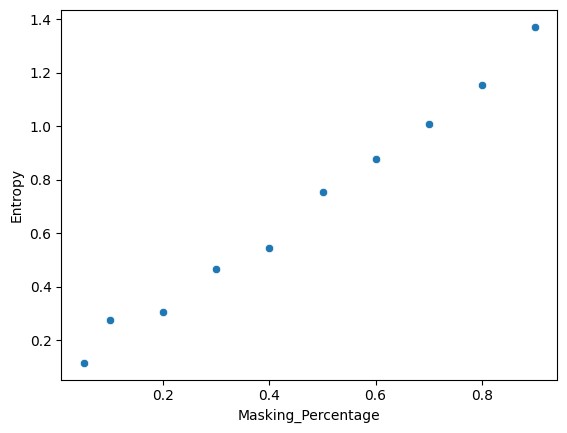

In [96]:
foo = entropy_by_subset_df[entropy_by_subset_df['Position'] == 18]
sns.scatterplot(x='Masking_Percentage', y='Entropy', data=foo)

In [101]:
original = "KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFTYGLQCFARYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGI"
original[85]
original[85-2:85+2]

mod = original[:85] + 'G' + original[86:]
mod

'M'

'SAMP'

'KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFTYGLQCFARYPDHMKRHDFFKSAGPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGI'

In [120]:
pos = 48
original[pos]
df['Generated_Sequence'].apply(lambda x: x[pos]).value_counts()
# calcualte the entropy at this postion
calculate_entropy(df[df['Backbone_RMSD'] < 2]['Generated_Sequence'].apply(lambda x: x[pos]))

'G'

Generated_Sequence
G    3990
K      84
D      83
E      82
L      80
A      75
S      73
P      69
T      62
V      61
I      60
N      53
Y      49
R      44
F      38
Q      32
M      19
H      17
C      17
W      12
Name: count, dtype: int64

[0.1331393286972457]